##TTim Pumping Test

In [1]:
# import ttim, numpy, matplotlib
from ttim import *
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

This exercise concerns the evaluation of the pumping test near the city of Oude Korendijk, described in the book 'Analysis and evaluation of pumping test data' by Kruseman and de Ridder. A pumping test is conducted in a confined aquifer extending form 18 m to 25 m below surface. The well penetrates the aquifer fully and is pumped at 788 m$^3$/day. Drawdown is measured in two observation wells, one at 30 m from the pumping well and one at 90 m from the pumping well. The data is provided in the files `oudekorendijk30.dat` and `oudekorendijk90.dat`. Time is given in minutes and drawdown in meters. Time is converted to days and drawdown to heads.

In [2]:
observed = np.loadtxt('oudekorendijk_h30.dat')
to1 = observed[:,0] / 60.0 / 24.0
ho1 = -observed[:,1]
ro1 = 30.0
observed = np.loadtxt('oudekorendijk_h90.dat')
to2 = observed[:,0] / 60.0 / 24.0
ho2 = -observed[:,1]
ro2 = 90.0
Qo = 788.0

A function is written that creates a ttim model, computes the head at the observation well and returns the sum of squared errors between the observed heads and the modeled heads. `tmin` and `tmax` are selected to match the data. Input arguments of the function are the hydraulic conductivity and the specific storage coefficient of the aquifer. The function takes a second optional argument `returnheads` which returns the heads rather than the sum of squared errors, which comes in handy once the optimal values of the parameters are found

In [4]:
def head_modeled1(p, returnheads = False):
    #print p
    ml = ModelMaq(kaq=p[0], z=(-18,-25), Saq=p[1], tmin=1e-5, tmax=1)   
    w = Well(ml, xw=0, yw=0, rw=0.1, tsandQ=[(0, 788)], layers=0)
    ml.solve(silent='.')
    hm = ml.head(ro1, 0.0, to1, layers=[0])
    if returnheads: return hm
    return np.sum((hm[0] - ho1)**2)

The optimal values for the hydraulic conducitivity and specific storage are obtained using the `fmin` routine of the `scipy.optimize` package, which conducts a simplex search. It is not recommended to perform a Levenberg Marquardt optimization as numerical derivatives are often too inaccurate. Input arguments of the `fmin` function are the function to minimize and an array with the initial values of the parameters

In [5]:
from scipy.optimize import fmin
popt = fmin(head_modeled1, [10, 1e-4])

. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .Optimization terminated successfully.
         Current function value: 0.034076
         Iterations: 60
         Function evaluations: 132



Kruseman and de Ridder report optimal values obtained in a variety of ways and on both datasets as $T=370-437$ m$^2$/d and $S=1.6\cdot 10^{-4}-4.1\cdot 10^{-4}$. Optimal values with this first analysis are a bit higher for $T$ and a bit lower for $S$, while the fit is pretty good.

optimal values k and Ss: [  6.86489278e+01   1.60588426e-05]
optimal values T and S: 480.54249432 0.000112411898203
. sum of squares: 0.0340761390772
.


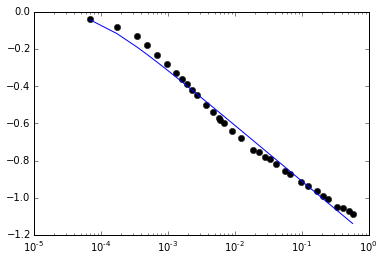

In [6]:
print 'optimal values k and Ss:', popt
print 'optimal values T and S:', popt[0] * 7, popt[1] * 7
sse = head_modeled1(popt)
print 'sum of squares:', sse
hm1 = head_modeled1(popt, returnheads=True)
plt.semilogx(to1, ho1, 'ko')
plt.semilogx(to1, hm1[0], 'b');

Kruseman and De Ridder don't include wellbore storage in their well, although early response of the well suggests wellbore storage is not negligible. Wellbore storage can be included and gives a much better fit, much lower sum of squared errors. In the example below a fixed well radius for wellbore storage of $r_c=0.2$ m is used, although this parameter may also be fitted. 

In [7]:
def head_modeled1_rc(p, returnheads = False):
    #print p
    ml = ModelMaq(kaq=p[0], z=(-18, -25), Saq=p[1], tmin=1e-5, tmax=1)   
    w = Well(ml, xw=0, yw=0, rw=0.1, rc=0.2, tsandQ=[(0, 788)], layers=0)
    ml.solve(silent='.')
    hm = ml.head(ro1, 0.0, to1, layers=[0])
    if returnheads: return hm
    return np.sum((hm[0] - ho1)**2)
popt_rc = fmin(head_modeled1_rc, [10, 1e-4])

. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .Optimization terminated successfully.
         Current function value: 0.012915
         Iterations: 60
         Function evaluations: 128



optimal values k and Ss: [  7.47100000e+01   9.47997152e-06]
optimal values T and S: 522.970000262 6.63598006227e-05
. sum of squares: 0.0129147608589
.


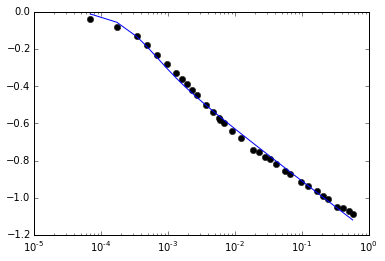

In [8]:
print 'optimal values k and Ss:', popt_rc
print 'optimal values T and S:', popt_rc[0] * 7, popt_rc[1] * 7
sse = head_modeled1_rc(popt_rc)
print 'sum of squares:', sse
hm1 = head_modeled1_rc(popt_rc, returnheads=True)
plt.semilogx(to1, ho1, 'ko')
plt.semilogx(to1, hm1[0], 'b');

Kruseman and De Ridder suggests that the confined aquifer may be underlain by a clay layer that leaks a bit of water. This may be seen from the data, where the observations seem to indicate a slight leveling-off of the drawdown and then a second increase due to release from the aquifer below. Mind you this is all fairly suttle, and may not be realistic, but it is easy to try to simulate the aquifer with an additional leaky layer. TTim requires this additional layer to be on top of the aquifer, but that gives the exact same mathematical solution as at the bottom of the aquifer (for a system consisting of one aquifer). The thickness of the additional layer is not important if the storage of the leaky layer is neglected. When the model is fitted, it should be prevented that one of the parameters becomes negative, which is obviously unrealistic and may lead to impossible solutions. Such safeguards are not built in here, and the optimization algorithm is able to find a solution, although quite a few iterations are needed. 

In [9]:
def head_modeled1_rc_semi(p, returnheads = False):
    #print p
    ml = ModelMaq(kaq=p[0], z=(-10, -18, -25), Saq=p[1], c=p[2], topboundary='semi', tmin=1e-5, tmax=1)   
    w = Well(ml, xw=0, yw=0, rw=0.1, rc=0.2, tsandQ=[(0, 788)], layers=0)
    ml.solve(silent='.')
    hm = ml.head(ro1, 0.0, to1, layers=[0])
    if returnheads: return hm
    return np.sum((hm[0] - ho1)**2)
popt_rc_semi = fmin(head_modeled1_rc_semi, [10, 1e-4, 5000])

. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .Opt

The sum of squares is again smaller and the fit is nicer, although no analysis of overfitting has been performed. 

optimal values k, Ss, and c: [  6.93114724e+01   1.17285394e-05   7.99059880e+03]
optimal values T and S: 485.180306935 8.20997761468e-05
. sum of squares: 0.0056510199108
.


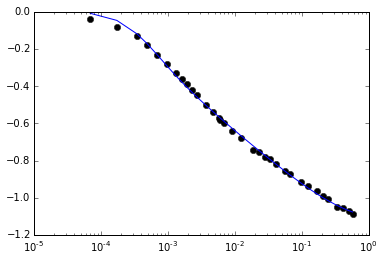

In [10]:
print 'optimal values k, Ss, and c:', popt_rc_semi
print 'optimal values T and S:', popt_rc_semi[0] * 7, popt_rc_semi[1] * 7
sse = head_modeled1_rc_semi(popt_rc_semi)
print 'sum of squares:', sse
hm1 = head_modeled1_rc_semi(popt_rc_semi, returnheads=True)
plt.semilogx(to1, ho1, 'ko')
plt.semilogx(to1, hm1[0], 'b');

###Exercise
Find optimal values for $k$ and $S_s$ for the measurements at the observation well at $r=90$ m.

In [11]:
def head_modeled2_rc(p, returnheads=False):
    #print p
    ml = ModelMaq(kaq = p[0], z = (-18, -25), Saq=p[1], tmin=1e-5, tmax=1)   
    w = Well(ml, xw=0, yw=0, rw=0.1, rc=0.2, tsandQ=[(0, 788)], layers=0)
    ml.solve(silent='.')
    hm = ml.head(ro2, 0.0, to2, layers = [0])
    if returnheads: return hm
    return np.sum((hm[0] - ho2)**2)
popt2_rc = fmin(head_modeled2_rc, [10, 1e-4])

. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .Optimization terminated successfully.
         Current function value: 0.013469
         Iterations: 60
         Function evaluations: 125



optimal values k and Ss: [  7.32465252e+01   2.65067917e-05]
optimal values T and S: 512.72567648 0.000185547541795
. sum of squares: 0.0134693036635
.

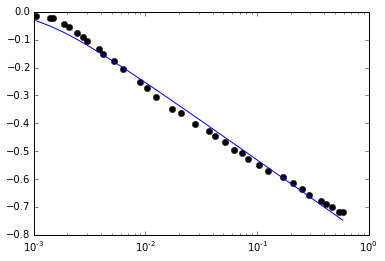

In [12]:
print 'optimal values k and Ss:', popt2_rc
print 'optimal values T and S:', popt2_rc[0] * 7, popt2_rc[1] * 7
sse = head_modeled2_rc(popt2_rc)
print 'sum of squares:', sse
hm2 = head_modeled2_rc(popt2_rc, returnheads=True)
plt.semilogx(to2, ho2, 'ko')
plt.semilogx(to2, hm2[0], 'b')

In [13]:
def head_modeled2_rc_semi(p, returnheads = False):
    #print p
    ml = ModelMaq(kaq=p[0], z=(-10, -18, -25), Saq=p[1], c=p[2], topboundary='semi', tmin=1e-5, tmax=1)   
    w = Well(ml, xw=0, yw=0, rw=0.1, rc=0.2, tsandQ=[(0, 788)], layers=0)
    ml.solve(silent='.')
    hm = ml.head(ro2, 0.0, to2, layers=[0])
    if returnheads: return hm
    return np.sum((hm[0] - ho2)**2)
popt2_rc_semi = fmin(head_modeled2_rc_semi, [70, 1e-4, 5000])

. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .Optimization terminated successfully.
         Current function value: 0.004701
         Iterations: 176
         Function evaluations: 333



optimal values k, Ss, c: [  6.33124090e+01   3.02842161e-05   2.56361926e+03]
optimal values T and S: 443.186863092 0.000211989512997
. sum of squares: 0.00470057252259
.

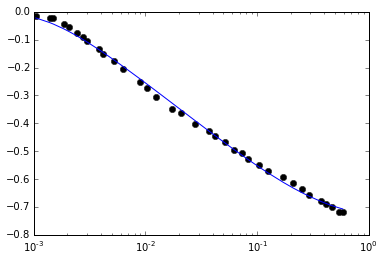

In [14]:
print 'optimal values k, Ss, c:', popt2_rc_semi
print 'optimal values T and S:', popt2_rc_semi[0] * 7, popt2_rc_semi[1] * 7
sse = head_modeled2_rc_semi(popt2_rc_semi)
print 'sum of squares:', sse
hm2 = head_modeled2_rc_semi(popt2_rc_semi, returnheads=True)
plt.semilogx(to2, ho2, 'ko')
plt.semilogx(to2, hm2[0], 'b')